In [ ]:
 #C1
# Importar librerias

import numpy as np
import matplotlib.pyplot as plt
import time

import keras


# Librerias para la red convolucional
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Librerias para cargar imagenes

from PIL import Image
import glob

# Libreria para Depth-tospace

import tensorflow as tf


In [ ]:
# Definir la base de datos

from PIL import Image
import glob

# AigleRN - 38 imagenes

from google.colab import drive
drive.mount('/content/drive')

# Directorio que contiene las imágenes originales
dir_img = '/content/drive/MyDrive/images_redimension'
# Directorio de salida para las imágenes preprocesadas
dir_lab = '/content/drive/MyDrive/prueba_salida'

image_list = []
label_list = []

background_color = np.array([255, 0, 255])  ## Solo el magenta

for filename in glob.glob('/content/drive/MyDrive/images_redimension/*.png'):
    im=Image.open(filename)
    image_list.append(np.asarray(im))
    #image_list.append(np.asarray(np.expand_dims(im, axis=0)))


    filename1 = filename.replace('images_redimension', 'prueba_salida')
    filename2 = filename1.replace('grieta', 'label_grieta')
    la=Image.open(filename2)

    gt_image = np.asarray(la)
    gt_bg = np.all(gt_image == background_color, axis=2)  #Binarizar la segmentación del target
    label_list.append(np.expand_dims(gt_bg,axis=2))


    #label_list.append(np.asarray(np.expand_dims(la, axis=0)))




print ('Total de imagenes: ', len(image_list))
print ('Total de labels: ', len(label_list))

Mounted at /content/drive
Total de imagenes:  325
Total de labels:  325


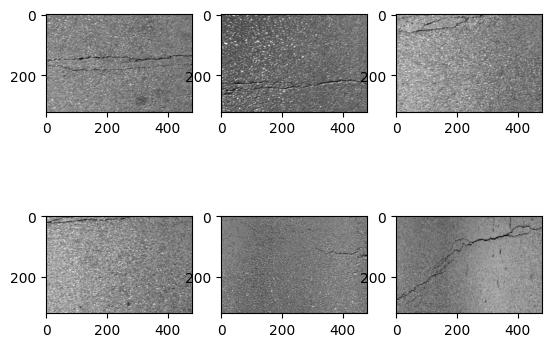

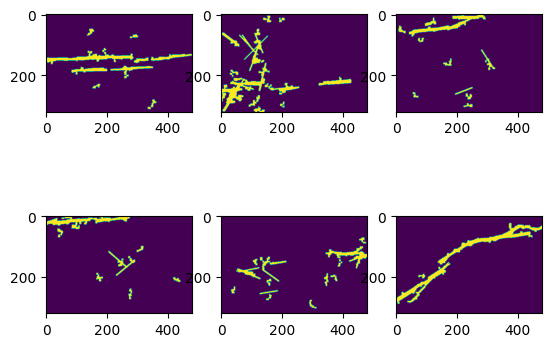

Tamaño del set de entrenamiento:  260
Tamaño del set de prueba:  65
260
65


In [ ]:
# Visualizar y acomodar los datos

# Visualizar los datos
fig = plt.figure()
for i in range (0,6):
  a = fig.add_subplot(2,3,i+1)
  plt.imshow(image_list[i])
plt.show()

fig1 = plt.figure()
for j in range (0,6):
  b = fig1.add_subplot(2,3,j+1)
  plt.imshow(label_list[j][:,:,0])
plt.show()


# Separar los datos en conjunto de entrenamiento y prueba

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.20, random_state=42)


print('Tamaño del set de entrenamiento: ',len(X_train))
print('Tamaño del set de prueba: ', len(X_test))
print(len(y_train))
print(len(y_test))

In [ ]:
# Modelo Depth-to-space

def SubpixelConv2D(input_shape, scale=4):
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [ ]:
# Modelo: Reducido con Depth-to-space
input_size = (320,480,3)

size = (5,5)

def unetU(input_size = (320,480,3)):

    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)

    conv1 = Conv2D(64, size, padding='same', activation='relu')(s)
    conv2 = Conv2D(64, size, padding='same', activation='relu')(conv1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, size, padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, size, padding='same', activation='relu')(conv3)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, size, padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, size, padding='same', activation='relu')(conv5)

    sub1 = SubpixelConv2D(conv6.shape,scale = 4)(conv6)

    conv7 = Conv2D(64, size, padding='same', activation='relu')(sub1)
    conv8 = Conv2D(64, size, padding='same', activation='relu')(conv7)

    merge1 = concatenate([conv8, conv2], axis=3)

    conv9 = Conv2D(128, size, padding='same', activation='relu')(merge1)

    y = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=inputs, outputs=y)

model = unetU(input_size)

model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 320, 480, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 480, 64  4864        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Entrenar el modelo

log = model.fit(x=np.array(X_train)
          ,y=np.array(y_train)
          ,epochs=50 # Numero de epocas
          ,batch_size=2
          ,validation_data=(np.array(X_test),np.array(y_test)))

Epoch 1/50
130/130 [==============================] - 84s 512ms/step - loss: 0.3934 - accuracy: 0.8833 - val_loss: 0.2485 - val_accuracy: 0.9349
Epoch 2/50
130/130 [==============================] - 62s 478ms/step - loss: 0.2585 - accuracy: 0.9306 - val_loss: 0.2455 - val_accuracy: 0.9349
Epoch 3/50
130/130 [==============================] - 61s 473ms/step - loss: 0.2540 - accuracy: 0.9306 - val_loss: 0.2417 - val_accuracy: 0.9349
Epoch 4/50
130/130 [==============================] - 62s 474ms/step - loss: 0.2494 - accuracy: 0.9306 - val_loss: 0.2444 - val_accuracy: 0.9349
Epoch 5/50
130/130 [==============================] - 63s 481ms/step - loss: 0.2456 - accuracy: 0.9306 - val_loss: 0.2334 - val_accuracy: 0.9349
Epoch 6/50
130/130 [==============================] - 62s 475ms/step - loss: 0.2397 - accuracy: 0.9306 - val_loss: 0.2284 - val_accuracy: 0.9349
Epoch 7/50
130/130 [==============================] - 62s 475ms/step - loss: 0.2332 - accuracy: 0.9306 - val_loss: 0.2226 - val_ac

1/1 [==============================] - 0s 20ms/step
Tiempo de ejecucion:  0.16097426414489746


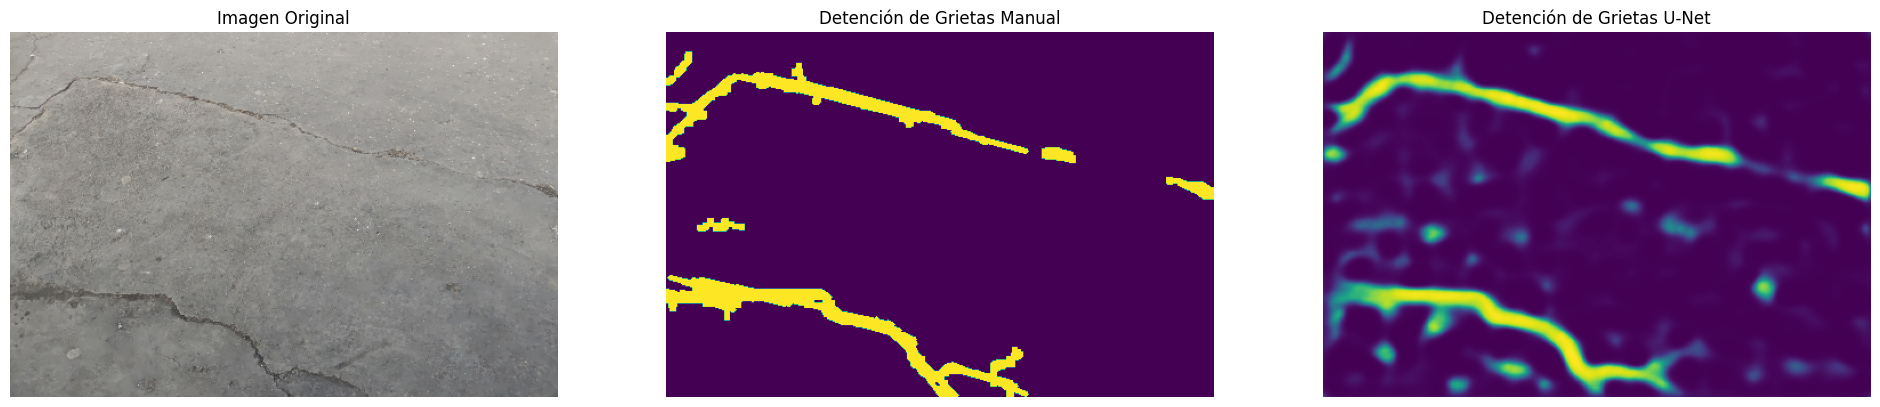

In [ ]:
# Probar el modelo con una sola imagen
t_l = y_test [5]
t1 = t_l[:,:,0]


inicio = time.time()
pred = model.predict(np.expand_dims(X_test[5],axis=0))
fin = time.time()
print ('Tiempo de ejecucion: ', fin-inicio)

plt.figure(figsize=(24, 6))

plt.subplot(131)
plt.imshow(X_test[5])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(t1)
plt.title('Detención de Grietas Manual')
plt.axis('off')

plt.subplot(133)
plt.imshow(pred[0,:,:,0])
plt.title('Detención de Grietas U-Net')
plt.axis('off')

plt.show()

In [ ]:
from keras import backend as K
# Utilizar el F1-score para medir el desempeño

# Segmentación manual
t_l = y_test [0]
t1 = t_l[:,:,0]

# Convertirlo a digito
t1 = t1 * 1

#Predicción

predic = model.predict(np.expand_dims(X_test[0],axis=0))
pred = predic[0,:,:,0]
# Aplicar un umbral de decisión
threshold = 0.01
predh = [pred > threshold]
predh = np.multiply(predh,1)
predh = predh[0,:,:]


# Para poder encontrar el handicap de los 2 pixeles se utiliza la siguiente funcion
tp = 0
fp = 0
fn = 0
h = 2       ######################### numero de pixeles alejado del punto a revisar
for r in range(len(t1)):
    for o in range(len(t1[0])):
        if t1[r][o] == 1 and predh[r-h:r+h,o-h:o+h].sum() >= 1:
            tp += 1
        elif t1[r][o] == 1 and predh[r][o] == 0:
            fp += 1
        elif t1[r][o] == 0 and predh[r][o] == 1:
            fn += 1
pr = tp/(tp+fp +K.epsilon())
re = tp/(tp+fn +K.epsilon())
f1 = 2*(pr*re)/(pr+re +K.epsilon())

print('El valor de precision es: ', pr)
print('El valor de recall es: ', re)
print('El valor de F1 - score es: ', f1)

1/1 [==============================] - 0s 21ms/step
El valor de precision es:  0.999999999986051
El valor de recall es:  0.11249901922304825
El valor de F1 - score es:  0.20224558793620814


In [ ]:
# Valor de F1-para todos los el set de prueba

for i in range (0,10):
    # Segmentación manual
  t_l = y_test [i]
  t1 = t_l[:,:,0]

  # Convertirlo a digito
  t1 = t1 * 1

  #Predicción

  predic = model.predict(np.expand_dims(X_test[i],axis=0))
  pred = predic[0,:,:,0]
  # Aplicar un umbral de decisión
  threshold = 0.01
  predh = [pred > threshold]
  predh = np.multiply(predh,1)
  predh = predh[0,:,:]

  # Para poder encontrar el handicap de los 2 pixeles se utiliza la siguiente funcion
  tp = 0
  fp = 0
  fn = 0
  h = 2       ######################### numero de pixeles alejado del punto a revisar
  for r in range(len(t1)):
      for o in range(len(t1[0])):
          if t1[r][o] == 1 and predh[r-h:r+h,o-h:o+h].sum() >= 1:
              tp += 1
          elif t1[r][o] == 1 and predh[r][o] == 0:
              fp += 1
          elif t1[r][o] == 0 and predh[r][o] == 1:
              fn += 1
  pr = tp/(tp+fp +K.epsilon())
  re = tp/(tp+fn +K.epsilon())
  f1 = 2*(pr*re)/(pr+re +K.epsilon())

  #print('El valor de precision es: ', pr)
  #print('El valor de recall es: ', re)
  print('El valor de F1 - score es: ', f1)

1/1 [==============================] - 0s 20ms/step
El valor de F1 - score es:  0.20224558793620814
1/1 [==============================] - 0s 18ms/step
El valor de F1 - score es:  0.10714909146256837
1/1 [==============================] - 0s 22ms/step
El valor de F1 - score es:  0.15538170658890768
1/1 [==============================] - 0s 18ms/step
El valor de F1 - score es:  0.11367732140984309
1/1 [==============================] - 0s 22ms/step
El valor de F1 - score es:  0.36443924887177936
1/1 [==============================] - 0s 18ms/step
El valor de F1 - score es:  0.2791502262066369
1/1 [==============================] - 0s 18ms/step
El valor de F1 - score es:  0.08510182097602469
1/1 [==============================] - 0s 18ms/step
El valor de F1 - score es:  0.15028766164871124
1/1 [==============================] - 0s 20ms/step
El valor de F1 - score es:  0.40924812395291055
1/1 [==============================] - 0s 21ms/step
El valor de F1 - score es:  0.277132472052986


<function matplotlib.pyplot.show(close=None, block=None)>

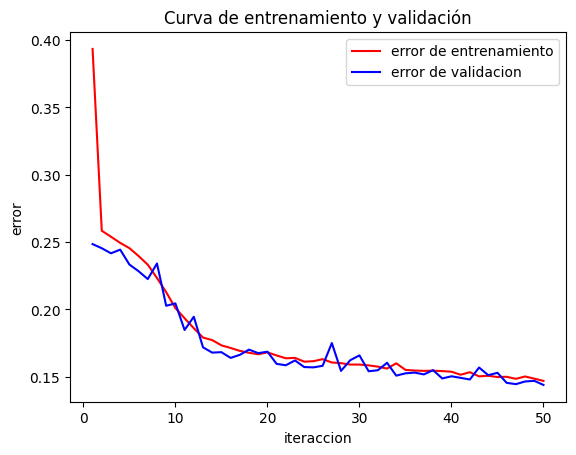

In [ ]:
error=log.history['loss']
val_error=log.history['val_loss']
epochs=range(1,len(error)+1)
plt.plot(epochs,error,color='red',label='error de entrenamiento')
plt.plot(epochs,val_error,color='blue',label='error de validacion')
plt.title('Curva de entrenamiento y validación')
plt.xlabel('iteraccion')
plt.ylabel('error')
plt.legend()
plt.show

3/3 [==============================] - 41s 362ms/step
True Positives: 283220 ( 43.58404185742315 %)
False Positives: 137351 ( 1.4714851607131856 %)
True Negatives: 9196824 ( 98.52851483928681 %)
False Negatives: 366605 ( 56.41595814257685 %)
Precision: 0.673417805792601
Recall: 0.4358404185742315


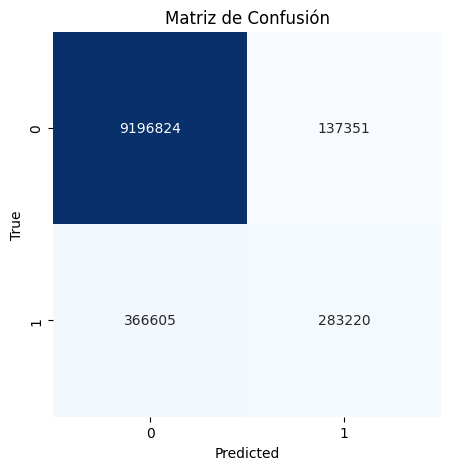

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(np.array(X_test))

# Redondear las predicciones a 0 o 1 (ya que es un problema de clasificación binaria)
y_pred_binary = np.round(y_pred).ravel()

# Convertir las etiquetas del conjunto de prueba a formato binario
y_test_binary = np.round(y_test).ravel()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Calcular los valores de interés
true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

# Calcular precision y recall
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

# Calcular porcentajes
total_samples = len(y_test_binary)
total_positives = true_positive + false_negative
total_negatives = true_negative + false_positive

percent_true_positive = (true_positive / total_positives) * 100
percent_false_positive = (false_positive / total_negatives) * 100
percent_true_negative = (true_negative / total_negatives) * 100
percent_false_negative = (false_negative / total_positives) * 100

# Mostrar los valores en la consola
print("True Positives:", true_positive, "(", percent_true_positive, "%)")
print("False Positives:", false_positive, "(", percent_false_positive, "%)")
print("True Negatives:", true_negative, "(", percent_true_negative, "%)")
print("False Negatives:", false_negative, "(", percent_false_negative, "%)")

print("Precision:", precision)
print("Recall:", recall)

# Mostrar la matriz de confusión como un gráfico de calor
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()